In [20]:
import trace_pb2
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline


In [21]:
attributes = [
    # data,
    "scan_name",
    "start_frequency",
    "stop_frequency",
    "resolution_bandwidth",
    "video_bandwidth",
    "reference_level",
    "sweep_points",
    "auto_sweep_time",
    "sweep_time",
    "single_sweep_mode",
    "number_of_sweeps",
    "dwell_time",
    "coupling",
    "pre_amp_state",
    "attenuation",
    "auto_attenuation",
    "antenna_offset",
    "detector_type",
    "trace_type",
    "latitude",
    "longitude",
    "azimuth",
    "elevation",
    "measurement_date_time",
    "significant_digits",
]


In [22]:
trace = trace_pb2.Trace()
try:
    f = open("trace.ptc", "rb")
    trace.ParseFromString(f.read())
    f.close()
except IOError:
    print(sys.arg[1] + ": Could not open file.")


In [23]:
for att in attributes:
    print("{}: {}".format(att, getattr(trace, att)))


scan_name: 2G to 9G
start_frequency: 2000.0
stop_frequency: 9000.0
resolution_bandwidth: 0.09
video_bandwidth: 0.09
reference_level: -10
sweep_points: 100001
auto_sweep_time: -1
sweep_time: 10
single_sweep_mode: -1
number_of_sweeps: 6
dwell_time: 20
coupling: 1
pre_amp_state: 0
attenuation: 0
auto_attenuation: -1
antenna_offset: 0
detector_type: 0
trace_type: 0
latitude: 21.984987
longitude: -159.752488
azimuth: 90
elevation: 22
measurement_date_time: Tuesday, April 23, 2019
significant_digits: 1


In [24]:
data_y = np.array(trace.data) / (10**int(trace.significant_digits))


In [25]:
print(data_y[0:3])


[-93.9 -92.2 -91.4]


In [26]:
data_x = np.linspace(
    trace.start_frequency,
    trace.stop_frequency,
    len(data_y)
)


In [27]:
print(data_x[0])
print(data_x[-1])
print(data_x.shape)

2000.0
9000.0
(100001,)


In [28]:
antenna = pd.read_csv("Qpar218.ant", header=1)
print(antenna.head())


   ! MHz  Gain(dB)     AF
0   2000      18.7  17.55
1   3000      21.6  18.17
2   4000      24.2  18.07
3   5000      25.7  18.51
4   6000      26.7  19.09


In [29]:
ant_x = np.array(antenna["! MHz"])
ant_y_db = np.array(antenna["Gain(dB)"])
ant_y_af = np.array(antenna["AF"])


In [30]:
print(ant_x.shape)



(17,)


In [31]:
interpolator_db = interpolate.interp1d(ant_x, ant_y_db)
interpolator_af = interpolate.interp1d(ant_x, ant_y_af)


In [32]:
interpd_ant_data_db = interpolator_db(data_x)
interpd_ant_data_af = interpolator_af(data_x)


In [33]:
print(interpd_ant_data_db.shape)
print(interpd_ant_data_af.shape)



(100001,)
(100001,)


In [34]:
def scale_data(data, antenna_factors, losses):
    # dBm to dB/m
    scaled_data = np.fromiter(
        (x + y for x, y in zip(data, antenna_factors)),
        "float64"
    )

    # dBm/m to dBuV/m
    scaled_data = np.add(scaled_data, 107)

    # Add in losses
    scaled_data = np.fromiter(
        (x + y for x, y in zip(scaled_data, losses)),
        "float64"
    )

    return scaled_data



In [35]:
scaled_data = scale_data(data_y, interpd_ant_data_af, np.zeros(len(data_y)))


In [36]:
print(scaled_data[0:4])



[30.65      32.3500434 33.1500868 37.3501302]


In [37]:
def plot_trace(
    trace_x,
    trace_y,
    title="Trace Plot",
    xlabel="Frequency (MHz)",
    ylabel="Amplitude (dBuV/m)"
):
    plt.plot(trace_x, trace_y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



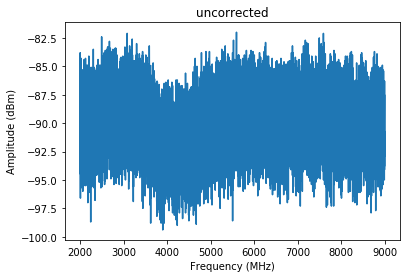

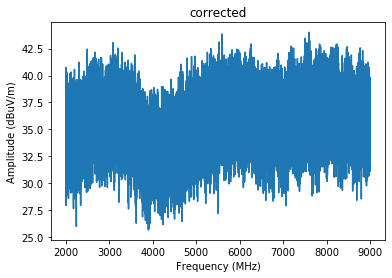

In [38]:
plot_trace(data_x, data_y, title="uncorrected", ylabel="Amplitude (dBm)")
plot_trace(data_x, scaled_data, title="corrected")
